In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# load the data
data = pd.read_csv('../data/benchmark_features.csv')

display(data.head())
print(data.shape)

,test_Opiate300_0,test_Opiate300_1,test_Opiate300_2,test_Opiate300_3,test_Opiate300_4,survey_opiates_0,survey_opiates_4,meds_methadone_0,meds_buprenorphine_0,meds_methadone_1,...,pex_musculoskeletal,pex_gi_system,pex_extremeties,pex_neurological,pex_gen_appearance,pex_ears_nose_throat,pex_head_neck,pex_cardio,pex_skin,dropout
0,1.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,8.0,0.0,...,abnormal,abnormal,normal,normal,normal,normal,normal,normal,normal,0.0
1,1.0,1.0,1.0,1.0,1.0,30.0,5.0,0.0,8.0,0.0,...,normal,abnormal,normal,normal,abnormal,abnormal,normal,normal,abnormal,0.0
2,1.0,1.0,1.0,1.0,1.0,30.0,9.0,30.0,0.0,170.0,...,normal,normal,normal,normal,normal,normal,normal,normal,abnormal,0.0
3,1.0,1.0,0.0,1.0,1.0,30.0,6.0,0.0,16.0,0.0,...,normal,normal,normal,normal,normal,normal,normal,normal,normal,0.0
4,1.0,1.0,1.0,1.0,1.0,5.0,0.0,0.0,16.0,0.0,...,normal,abnormal,abnormal,normal,abnormal,abnormal,normal,normal,abnormal,1.0


(1321, 61)


In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, log_loss

# assign X and y
X, y = data.drop('dropout', axis=1), data['dropout']

## Assign columns to dtype for pipelines

In [3]:
# start with int and float
int_columns = [col for col in X.columns if X[col].dtype == 'int64']
float_columns = [col for col in X.columns if X[col].dtype == 'float64']

# Combine both lists if you need columns of both types
numeric_columns = int_columns + float_columns

# get categorical columns
categorical_columns = [col for col in X.columns if X[col].dtype == 'object']

### Using C-Index as calssification metric

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer
import helper  # Assuming helper.cindex() is defined in helper module

# Define the custom scoring function
def cindex_scorer(y_true, y_pred):
    return helper.cindex(y_true, y_pred)

# Create a scorer object
cindex = make_scorer(cindex_scorer, greater_is_better=True)

# Instantiate the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ])

# Define the classifiers
classifiers = {
    'LogisticRegression': LogisticRegression(),
    'RandomForest': RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier()
}

# Define pipelines for each classifier
pipelines = {
    name: Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', classifier)])
    for name, classifier in classifiers.items()
}

# Define parameter grids for each classifier
param_grids = {
    'LogisticRegression': {'classifier__C': [0.1, 1, 10]},
    'RandomForest': {'classifier__n_estimators': [10, 50, 100], 
                     'classifier__max_depth': [3, 5, 10]},
    'XGBoost': {'classifier__learning_rate': [0.01, 0.1, 0.3],
                'classifier__n_estimators': [200, 300, 400]}
}

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize results storage
results = {}

# Run GridSearchCV for each pipeline
for name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring=cindex)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = helper.cindex(y_test, y_pred)
    loss = log_loss(y_test, best_model.predict_proba(X_test))
    results[name] = {'cindex': accuracy, 'loss': loss}

print(results)

{'LogisticRegression': {'cindex': 0.7262396694214877, 'loss': 0.5319344782648302}, 'RandomForest': {'cindex': 0.8794765840220385, 'loss': 0.4338892397242504}, 'XGBoost': {'cindex': 0.8849288337924701, 'loss': 0.3463123290372171}}


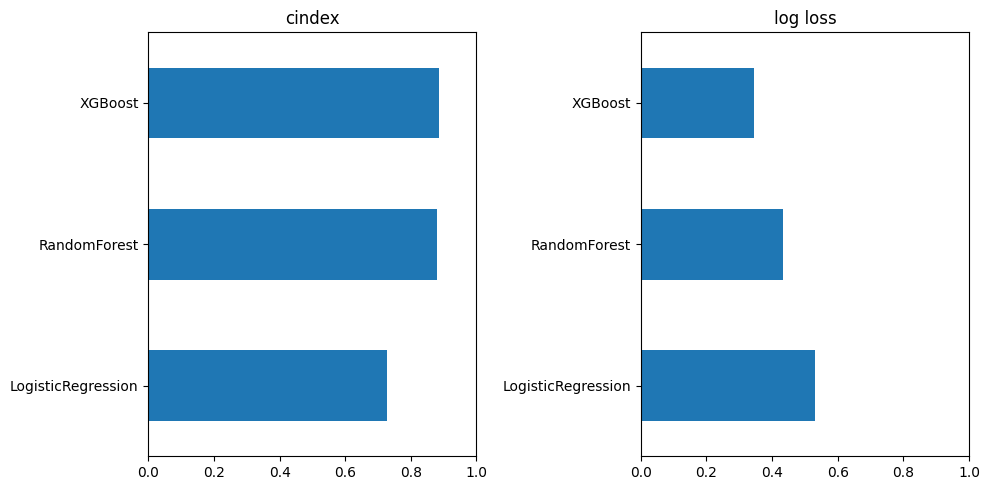

In [5]:
# plot results from results dict
results_df = pd.DataFrame(results).T

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
results_df['cindex'].plot(kind='barh', ax=ax[0], title='cindex', xlim=(0, 1))
results_df['loss'].plot(kind='barh', ax=ax[1], title='log loss', xlim=(0, 1))
plt.tight_layout()
plt.show()


### Using AUC as classification metric

In [7]:

# Instantiate the ColumnTransformer
preprocessor = ColumnTransformer(
	transformers=[
		('num', StandardScaler(), numeric_columns),
		('cat', OneHotEncoder(), categorical_columns)
	])

# Define the classifiers
classifiers = {
	'LogisticRegression': LogisticRegression(),
	'RandomForest': RandomForestClassifier(),
	'XGBoost': xgb.XGBClassifier()
}

# Define pipelines for each classifier
pipelines = {
	name: Pipeline(steps=[('preprocessor', preprocessor),
						  ('classifier', classifier)])
	for name, classifier in classifiers.items()
}

# Define parameter grids for each classifier
param_grids = {
	'LogisticRegression': {'classifier__C': [0.1, 1, 10]},
	'RandomForest': {'classifier__n_estimators': [10, 50, 100], 
					 'classifier__max_depth': [3, 5, 10]},
	'XGBoost': {'classifier__learning_rate': [0.01, 0.1, 0.3],
				'classifier__n_estimators': [200, 300, 400]}
}

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize results storage
results = {}

# Run GridSearchCV for each pipeline
for name, pipeline in pipelines.items():
	grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring='accuracy')
	grid_search.fit(X_train, y_train)
	best_model = grid_search.best_estimator_
	y_pred = best_model.predict(X_test)
	accuracy = accuracy_score(y_test, y_pred)
	loss = log_loss(y_test, best_model.predict_proba(X_test))
	results[name] = {'accuracy': accuracy, 'loss': loss}

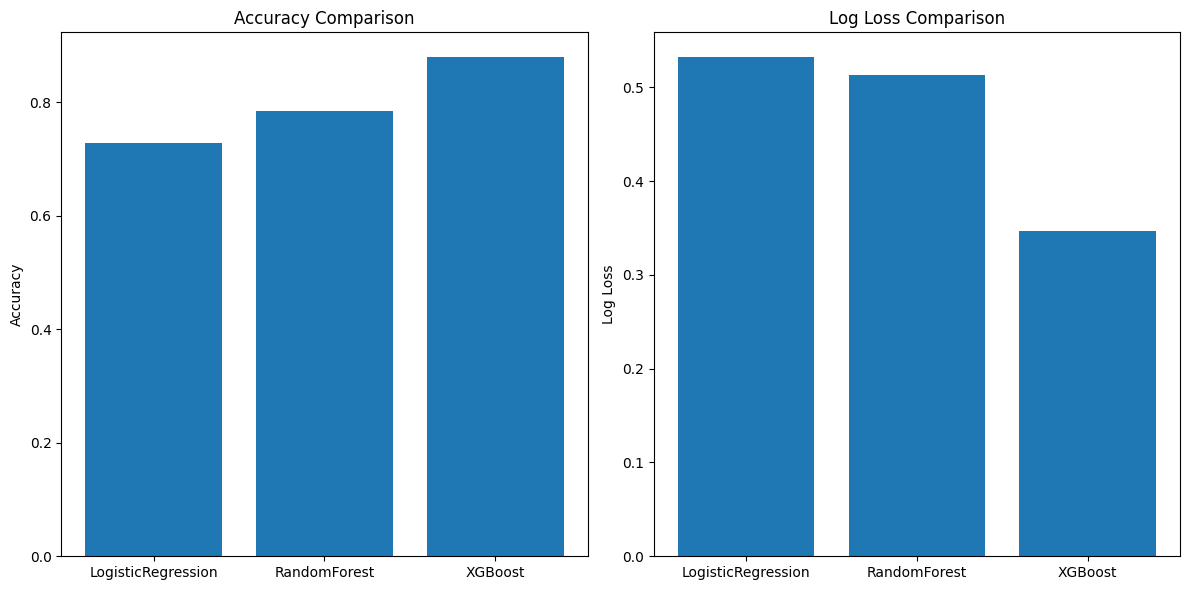

In [8]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
classifiers_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in classifiers_names]
losses = [results[name]['loss'] for name in classifiers_names]

# Plotting accuracy and loss with line plots
ax[0].bar(classifiers_names, accuracies, label='Accuracy')
ax[1].bar(classifiers_names, losses, label='Loss')

ax[0].set_title('Accuracy Comparison')
ax[0].set_ylabel('Accuracy')
ax[1].set_title('Log Loss Comparison')
ax[1].set_ylabel('Log Loss')
ax[0].set_xticks(range(len(classifiers_names)))
ax[0].set_xticklabels(classifiers_names, rotation=0)
ax[1].set_xticks(range(len(classifiers_names)))
ax[1].set_xticklabels(classifiers_names, rotation=0)

plt.tight_layout()
plt.show()

In [9]:
# loop through pipelines and create a cvresults df for each model
cv_results = {}
for name, pipeline in pipelines.items():
    cv_results[name] = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')

# Create a DataFrame with the results
cv_results_df = pd.DataFrame(cv_results)
cv_results_df

,LogisticRegression,RandomForest,XGBoost
0,0.701887,0.818868,0.811321
1,0.696970,0.833333,0.848485
2,0.712121,0.825758,0.791667
3,0.708333,0.799242,0.814394
4,NaN,NaN,NaN


In [10]:
# create classification report for all models for train and test data 
# save each report to dataframe
from sklearn.metrics import classification_report

# Initialize results storage
classification_reports = {}

# iterate over pipelines
for name, pipeline in pipelines.items():
    best_model = pipeline.fit(X_train, y_train)
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    report_train = classification_report(y_train, y_pred_train, output_dict=True)
    report_test = classification_report(y_test, y_pred_test, output_dict=True)
    classification_reports[name] = {'train': report_train, 'test': report_test}

# Create a DataFrame from the classification reports
df_reports = pd.DataFrame()
for model, reports in classification_reports.items():
    for dataset, report in reports.items():
        df = pd.DataFrame(report).T
        df['model'] = model
        df['dataset'] = dataset
        df_reports = pd.concat([df_reports, df])

# for df reports only include 'macro avg' in index
df_reports = df_reports[df_reports.index == 'macro avg']

# reorder columns for readability
df_reports = pd.concat([df_reports.model,df_reports.drop('model', axis=1)], axis=1)

# clean up axis for readability
df_reports.rename_axis('metric', inplace=True)

# filter columns to include for report and plots
df_reports = df_reports.reset_index().iloc[:,[0,1,2,5,6]]

df_reports.to_markdown()

from IPython.display import display, Markdown
display(Markdown(df_reports.to_markdown()))

|    | metric    | model              |   precision |   support | dataset   |
|---:|:----------|:-------------------|------------:|----------:|:----------|
|  0 | macro avg | LogisticRegression |    0.763542 |      1056 | train     |
|  1 | macro avg | LogisticRegression |    0.726571 |       265 | test      |
|  2 | macro avg | RandomForest       |    1        |      1056 | train     |
|  3 | macro avg | RandomForest       |    0.830722 |       265 | test      |
|  4 | macro avg | XGBoost            |    1        |      1056 | train     |
|  5 | macro avg | XGBoost            |    0.852137 |       265 | test      |

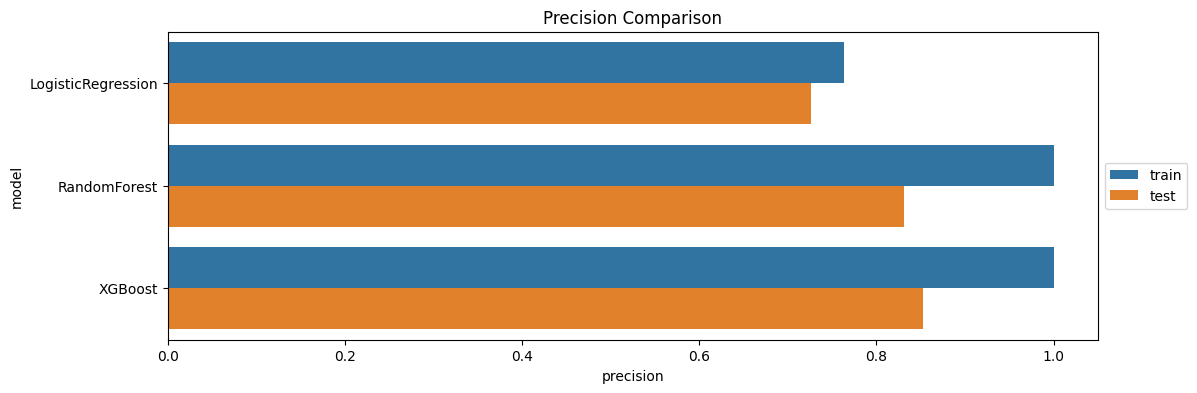

In [11]:
# create barplot with model as y, precision as x, and hue as dataset
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x='precision', y='model', hue='dataset', data=df_reports, ax=ax)
plt.title('Precision Comparison')
# put the legend out of the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
